Import

In [1]:
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')

from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc

from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import GPUtil
import copy


Parameters

In [25]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 10                                #Parameter of greedy optimizer, default 10
eps = 0.1                                       #Parameter of greedy optimizer, default 0.1
k = 10                                          #Parameter of greedy optimizer, default 5

num_epochs = 30         
batch_size = 1
learning_rate = 1e-3

num_layers = 4
activation = 'relu'
intermediate_size = 100

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 11
N_INSTANCES = 10 
N_TRAIN = int(0.8 * N_INSTANCES)


Device

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



##### Instances definition

In [5]:
path = "instances_weibo/oversampled_FE_LP_2/"

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(path + f"{instance}.npz")['arr_0']
        if instance in train_id :
            X_train[c_train] = XY[:,:,:-1]
            Y_train[c_train] = XY[:,:,-1]
            c_train += 1
        else : 
            X_test[c_test] = XY[:,:,:-1]
            Y_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    #Cheating line
    #X_train[:,:,:,9] = Y_train * 2

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test



Definition of dataset

In [6]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 


In [7]:
def print_training(loss, train, test, title = "") : 

    fig, ax = plt.subplots(1,2, figsize = (10,5))
    plt.suptitle(title)
    ax[0].plot(loss)
    ax[0].set_title('Learning curve')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(train, label="train_scores")
    ax[1].plot(test, label="test_scores")
    ax[1].set_title('Quality')
    ax[1].set_ylabel('influence')
    ax[1].set_xlabel('epoch')
    ax[1].legend()
    plt.show()
    

### Decision focused

Evaluation function

In [8]:
def eval_grd(net, X, Y):
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])

    return result

Training

In [26]:

print("epoch | loss | train_score | test_score ")

train_scores_df = []
test_scores_df  = []
loss_df = []

net_df = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net_df.apply(init_weights)
net_df = net_df.to(device)
#net = net.half()
net_df.modules

epoch | loss | train_score | test_score 


<bound method Module.modules of Sequential(
  (0): Linear(in_features=11, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
  (7): Hardtanh(min_val=0, max_val=1.0)
)>

0 | -641.3819580078125 | 634.7950973510742 | 630.1479187011719
1 | -618.77880859375 | 633.1996765136719 | 630.1479187011719
2 | -658.1292114257812 | 627.4301223754883 | 618.6668090820312
3 | -601.7238159179688 | 626.9901962280273 | 622.0751037597656
4 | -629.9630126953125 | 633.9727172851562 | 625.6167907714844
5 | -627.1560668945312 | 635.6409530639648 | 625.6167907714844
6 | -656.382568359375 | 646.7624893188477 | 635.8049926757812
7 | -615.6832275390625 | 105.68021202087402 | 106.58333587646484
8 | -614.3018188476562 | 105.68021202087402 | 106.58333587646484
9 | -607.0485229492188 | 105.68021202087402 | 106.58333587646484
10 | -612.2347412109375 | 105.68021202087402 | 106.58333587646484
11 | -618.8964233398438 | 105.68021202087402 | 106.58333587646484
12 | -621.024169921875 | 105.68021202087402 | 106.58333587646484
13 | -607.9194946289062 | 105.68021202087402 | 106.58333587646484
14 | -608.3514404296875 | 105.68021202087402 | 106.58333587646484
15 | -609.6941528320312 | 105.68021202

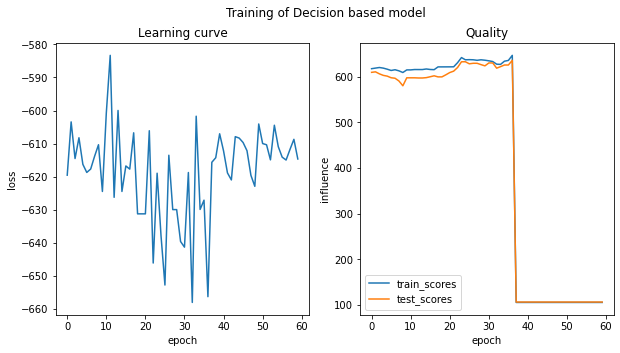

In [28]:

optimizer = torch.optim.Adam(net_df.parameters(), lr = learning_rate)
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(num_epochs):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_df(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net_df, X_train, Y_train)
    test_score  = eval_grd(net_df, X_test, Y_test)
    loss_df.append(loss.item())
    
    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores_df.append(train_score)
    test_scores_df.append(test_score)
    
print_training(loss_df, train_scores_df, test_scores_df, "Training of Decision based model")


Comparison with test network

In [58]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    
    X, Y = X.to(device), Y.to(device)
    th = np.mean([set_func(greedy(k, Y[i,:,:],w)[1],Y[i, :, :], w) for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"The model predicts maximum influence {pred}")
    print(f"The theoretical maximum influence is {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net_df, X_train, Y_train)

print("\n Decision_based on test dataset : ")
compare_grd(net_df, X_test, Y_test)

Decision_based on train dataset : 
The model predicts maximum influence 610.6737289428711
The theoretical maximum influence is 732.144172668457

 Decision_based on test dataset : 
The model predicts maximum influence 612.7291870117188
The theoretical maximum influence is 723.1104125976562


### 2 Stage

In [39]:
train_scores_2s = []
test_scores_2s  = []
loss_2s = []

net_2s = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net_2s.apply(init_weights)
net_2s = net_2s.to(device)

epoch | loss | train_score | test_score 
0 | 0.0763079822063446 | 607.3780517578125 | 597.6500854492188
1 | 0.07679274678230286 | 606.07421875 | 600.136962890625
2 | 0.07676452398300171 | 614.2244415283203 | 631.4229736328125
3 | 0.07674942165613174 | 625.4765472412109 | 629.5027770996094
4 | 0.07633203268051147 | 626.1758270263672 | 635.9569396972656
5 | 0.07611553370952606 | 630.3331680297852 | 637.5166931152344
6 | 0.07537773251533508 | 623.396110534668 | 638.7124938964844
7 | 0.07435000687837601 | 638.8218688964844 | 644.4375
8 | 0.07443546503782272 | 637.3705596923828 | 638.8875122070312
9 | 0.07338336110115051 | 637.5870513916016 | 640.7069702148438
10 | 0.07434364408254623 | 650.1169128417969 | 648.3409729003906
11 | 0.07429125905036926 | 642.6201324462891 | 645.0972290039062
12 | 0.07392190396785736 | 643.4979782104492 | 647.5972595214844
13 | 0.0744340792298317 | 645.8950347900391 | 654.7222595214844
14 | 0.07420376688241959 | 642.8647537231445 | 644.7333374023438


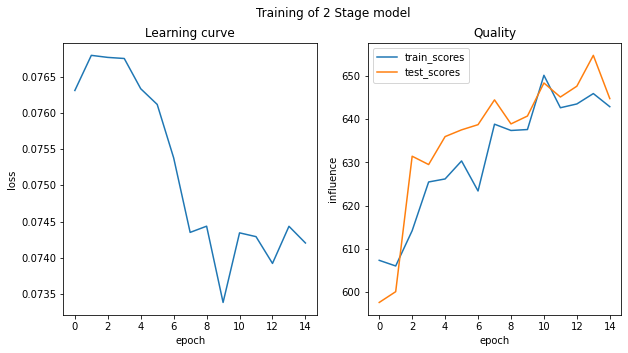

In [40]:
num_epochs = 15

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net_2s(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net_2s, X_train, Y_train)
    test_score  = eval_grd(net_2s, X_test, Y_test)
    print(f"{epoch} | {loss} | {train_score} | {test_score}")    
    train_scores_2s.append(train_score)
    test_scores_2s.append(test_score)     
    loss_2s.append(loss.item())

print_training(loss_2s, train_scores_2s, test_scores_2s,"Training of 2 Stage model")


In [61]:
print("2-stage on train dataset : ")
compare_grd(net_2s, X_train, Y_train)

print("\n 2-stage on test dataset : ")
compare_grd(net_2s, X_test, Y_test)

2-stage on train dataset : 
The model predicts maximum influence 627.8336181640625
The theoretical maximum influence is 732.144172668457

 2-stage on test dataset : 
The model predicts maximum influence 655.4230346679688
The theoretical maximum influence is 723.1104125976562


### Random

In [62]:
    
def eval_rnd(X, Y):
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

print(f"Average random score X_train : {np.mean([eval_rnd(X_train, Y_train) for _ in range(100)])}")
print(f"Average random score X_test : {np.mean([eval_rnd(X_test, Y_test) for _ in range(100)])}")


Average random score X_train : 610.0911435699463
Average random score X_test : 610.3462600708008


### Plots


(-0.08, 0.0)

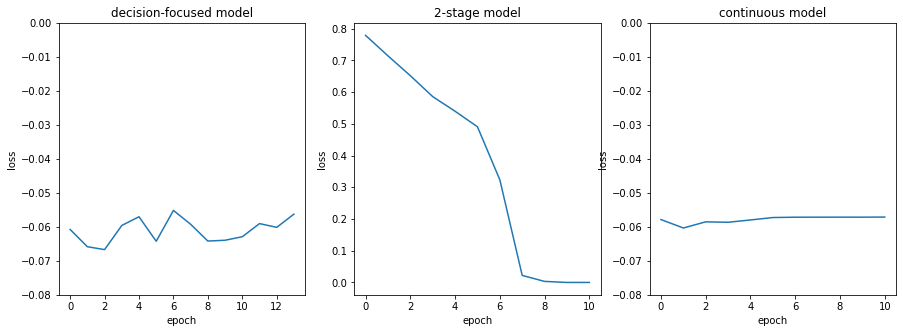

In [14]:
loss_decision = [-0.06076928973197937,-0.06584206968545914,-0.06670479476451874,-0.05958820879459381,-0.0570240244269371,-0.06424318253993988,-0.05516466125845909,-0.05924143642187118,-0.06418315321207047,-0.06394138187170029,-0.06290893256664276,-0.05904095247387886,-0.06015191227197647,-0.05625718086957931,]
loss_2_stage = [0.7789968252182007, 0.7144742012023926, 0.6519206762313843, 0.5859464406967163 ,0.5397264361381531 ,0.4908316731452942 ,0.32362160086631775, 0.022119728848338127, 0.00329726655036211, 9.616058378014714e-06,  1.4370152712217532e-06]
loss_CNT = [-0.057850807905197144,-0.06033829599618912,-0.058524295687675476,-0.05864942446351051,-0.057970765978097916,-0.05725716054439545,-0.05716206878423691,-0.0571533665060997,-0.057145409286022186,-0.05715050548315048,-0.05711754783987999,]

fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(loss_decision)
ax[0].set_title("decision-focused model")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_ylim(-0.08,0)

ax[1].plot(loss_2_stage)
ax[1].set_title("2-stage model")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(loss_CNT)
ax[2].set_title("continuous model")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("loss")
ax[2].set_ylim(-0.08,0)

Text(0.5, 0, 'epoch')

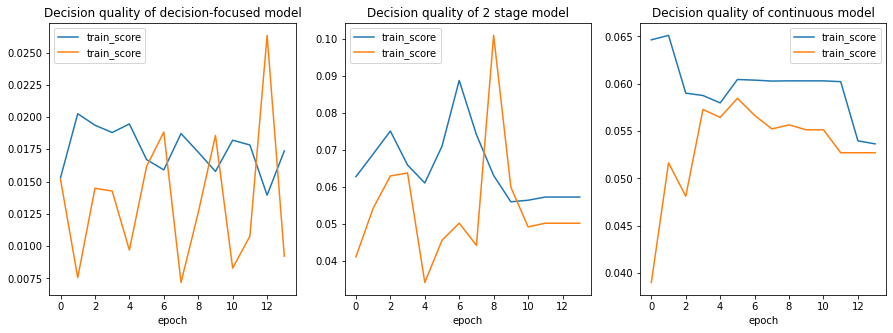

In [15]:
quality_decision_based_train=[0.015288348495960235,0.020257513225078582 ,0.01936897709965706  ,0.018799322098493575 ,.019463644921779634  ,0.016700024902820586 ,0.01590406075119972  ,0.01871654763817787  ,0.017278300225734712 ,0.015782848000526428 ,0.01820402070879936  ,0.017835138738155364 ,0.013945347815752029 ,0.01737329438328743  ]
quality_decision_based_test  = [0.015173667669296264,0.007551929354667664,0.014478504657745361,0.014267870783805847,0.009686842560768127,0.01617351770401001,0.01883455514907837,0.007182687520980835,0.012591168284416199,0.018572977185249327,0.008294036984443665,0.010770317912101746,0.02632948160171509,0.009215238690376281,]

quality_2_stage_train = [0.06274317726492881, 0.06885293275117874, 0.0750866748392582, 0.06588671803474426, 0.06102966964244842, 0.07097437083721161, 0.08876516669988632, 0.0741001047194004, 0.06304563134908676, 0.05594222992658615, 0.056365196406841275, 0.05722642466425896, 0.05722642466425896, 0.05722642466425896]
quality_2_stage_test = [0.04106912612915039,0.054186728596687314,0.06293168067932128,0.0637294352054596,0.034126061201095584,0.045535266399383545,0.050166568160057066,0.044150781631469724,0.1009661465883255,0.05989144742488861,0.04914851486682892,0.050147178769111636, 0.050147178769111636, 0.050147178769111636]

quality_CNT_train = [0.06463120132684708,0.06510359048843384  ,0.058999452739953995, 0.05875115767121315  ,0.057967768609523775 ,0.06044074296951294  ,0.06037365570664406  ,0.0602763794362545   ,0.060297693312168124 ,0.060297693312168124 ,0.060297693312168124 ,0.0602118082344532   ,0.0539618082344532   ,0.05364147499203682   ]
quality_CNT_test = [0.039006182551383974,0.05163630247116089,0.048112612962722776,0.05727651119232178,0.05643411874771118,0.058458879590034485,0.05664604902267456,0.055219563841819766,0.0556481271982193,0.05512729585170746,0.05512729585170746,0.05270652174949646,0.05270652174949646,0.05270652174949646]


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(quality_decision_based_train, label = "train_score")
ax[0].plot(quality_decision_based_test, label = "train_score")
ax[0].set_title("Decision quality of decision-focused model")
ax[0].legend()
ax[0].set_xlabel("epoch")

ax[1].plot(quality_2_stage_train, label = "train_score")
ax[1].plot(quality_2_stage_test, label = "train_score")
ax[1].set_title("Decision quality of 2 stage model")
ax[1].legend()
ax[1].set_xlabel("epoch")

ax[2].plot(quality_CNT_train, label = "train_score")
ax[2].plot(quality_CNT_test, label = "train_score")
ax[2].set_title("Decision quality of continuous model")
ax[2].legend()
ax[2].set_xlabel("epoch")


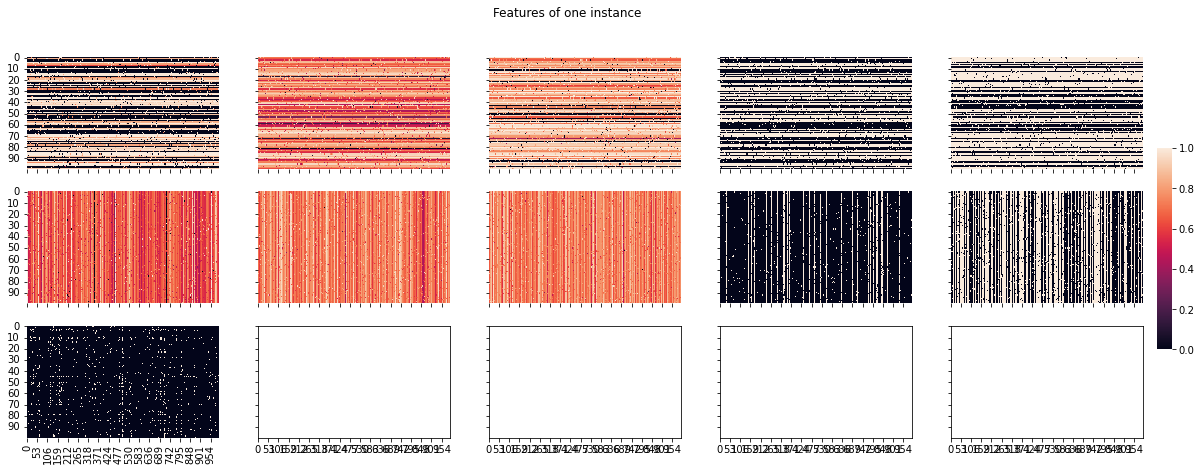

In [24]:
fig, axn = plt.subplots(3, 5, sharex=True, sharey=True, figsize = (20,7))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    if i > 10 : break
    sns.heatmap(X_train[1,:,:,i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)



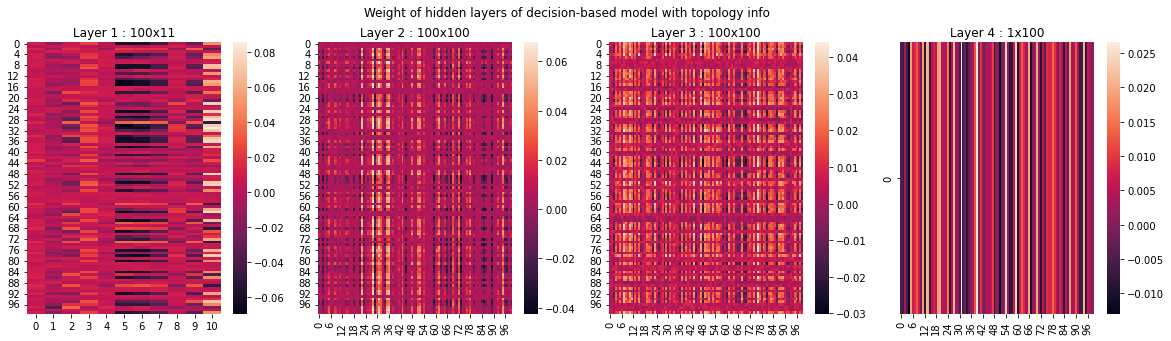

In [38]:
def print_hidden_layers(net, title) : 
    fig,ax = plt.subplots(1 , num_layers, figsize = (20,5))
    plt.suptitle(title)

    for i,ax in enumerate(ax.flat) :
        weights = net[2*i].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=ax)
        ax.set_title(f'Layer {i + 1} : {weights.shape[0]}x{weights.shape[1]}')
        
print_hidden_layers(net_df, 'Weight of hidden layers of decision-based model with topology info')
print_hidden_layers(net_2s, 'Weight of hidden layers of 2 stage model with topology info')

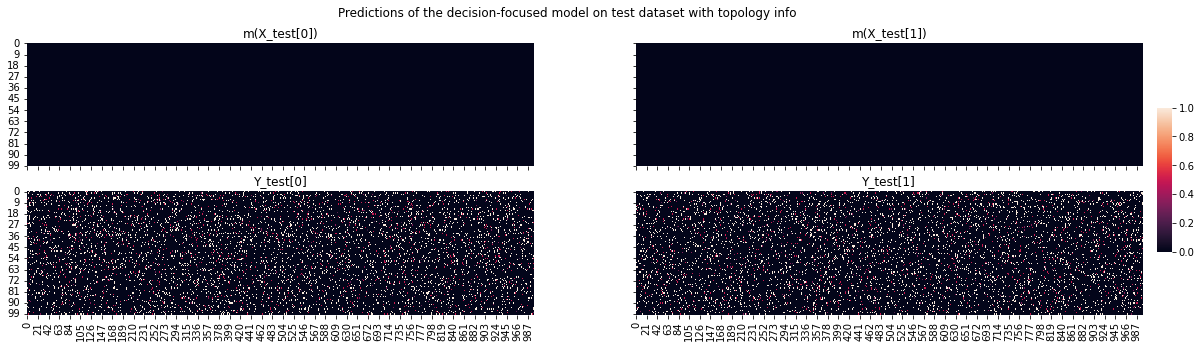

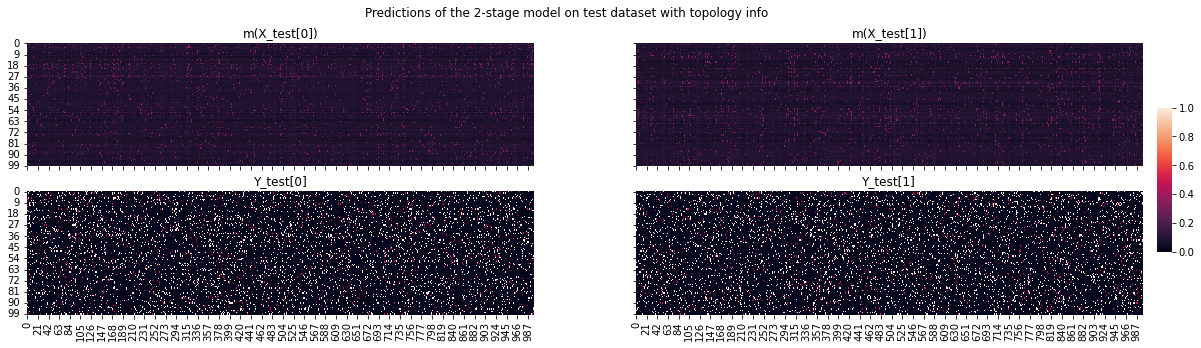

In [36]:
def print_output_test(net, title) :
    fig,ax = plt.subplots(2, 2, figsize = (20,5),sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .01, .4])
    #netcpu = copy.deepcopy(net).to('cpu')
    plt.suptitle(title)
    for i,ax in enumerate(ax.flat) :
        if i < 2 : 
            sns.heatmap(net(X_test[i]).view_as(Y_test[0]).detach(), 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'm(X_test[{i}])')
        else : 
            sns.heatmap(Y_test[i-2], 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'Y_test[{i-2}]')

print_output_test(net_df, "Predictions of the decision-focused model on test dataset with topology info")
print_output_test(net_2s, "Predictions of the 2-stage model on test dataset with topology info")

In [70]:
loss_df_cheat = [-616.76708984375, -626.2454833984375, -656.6033325195312, -686.2703857421875, -699.3722534179688, -714.6351318359375, -683.4835815429688, -698.6654052734375, -717.0424194335938, -686.1061401367188, -710.7937622070312, -719.3179931640625, -734.3993530273438, -734.3993530273438, -721.949951171875, -722.7680053710938, -718.9629516601562, -724.6202392578125, -733.5610961914062, -728.3310546875, -734.0625610351562, -725.25830078125, -734.3993530273438, -731.4889526367188, -728.6439208984375, -731.0556030273438, -722.762939453125, -731.1055908203125, -728.6141357421875, -734.3993530273438] 
train_df_cheat = [629.9470596313477, 638.5685501098633, 642.0366058349609, 703.2988510131836, 698.786247253418, 709.4888305664062, 699.473876953125, 712.2246627807617, 716.4704742431641, 711.5155563354492, 719.775032043457, 722.5051498413086, 721.8442840576172, 721.8442840576172, 721.8442840576172, 721.8442840576172, 723.5446319580078, 725.4313583374023, 726.6796112060547, 726.6796112060547, 726.4608688354492, 726.4608688354492, 727.2290420532227, 728.2420043945312, 729.2425994873047, 727.2290420532227, 726.692024230957, 726.551399230957, 728.2732467651367, 728.8333206176758] 
test_df_cheat = [605.38330078125, 607.0361328125, 607.0361328125, 596.6180419921875, 628.5375061035156, 613.8291931152344, 605.892333984375, 614.2778015136719, 634.3419799804688, 616.5736083984375, 602.6708679199219, 619.3488159179688, 637.6357116699219, 641.7950439453125, 646.4789123535156, 643.7948608398438, 654.0169677734375, 652.84521484375, 647.2266845703125, 647.2266845703125, 654.5975341796875, 651.2433471679688, 646.6016845703125, 640.8055419921875, 640.8055419921875, 645.3857116699219, 639.9603271484375, 632.5069580078125, 638.3273620605469, 638.2666625976562]

loss_2s_cheat = [0.07514822483062744, 0.07254979759454727, 0.06513979285955429, 0.048453375697135925, 0.02143559791147709, 0.0013291946379467845, 0.00014993258810136467, 0.0001558301883051172, 0.00013897819735575467, 0.00011833121970994398, 9.452990343561396e-05, 8.159576100297272e-05, 6.7353859776631e-05, 5.073147622169927e-05, 4.488118793233298e-05]
train_2s_cheat = [623.6631622314453, 650.1829223632812, 657.9133529663086, 640.093505859375, 645.1379776000977, 695.9493942260742, 730.6371917724609, 731.6124114990234, 731.9684829711914, 731.6785583496094, 731.6785583496094, 731.6785583496094, 731.2400131225586, 731.2400131225586, 731.2400131225586]
test_2s_cheat = [610.2027893066406, 605.4592895507812, 629.9775695800781, 626.3638000488281, 641.194091796875, 632.7218933105469, 638.4194641113281, 637.040283203125, 637.1872863769531, 636.5039672851562, 627.0595092773438, 627.0595092773438, 627.0595092773438, 628.5416259765625, 638.6458129882812]

loss_df = [-590.6621704101562, -613.7133178710938, -593.3753662109375, -590.0100708007812, -608.2012939453125, -617.9049682617188, -586.08349609375, -630.3292236328125, -608.1761474609375, -586.63818359375, -605.3233032226562, -586.8829956054688, -582.94921875, -611.841796875, -590.0680541992188, -607.3931884765625, -607.6980590820312, -619.517822265625, -605.1031494140625, -599.5083618164062, -604.5616455078125, -618.5628051757812, -595.2598876953125, -595.3056030273438, -616.2832641601562, -609.8016357421875, -616.5383911132812, -618.5928344726562, -602.7210693359375, -622.9998168945312]
train_df = [594.0173721313477, 604.7565155029297, 609.2598419189453, 611.4317092895508, 610.756721496582, 609.4155578613281, 603.27734375, 604.1050109863281, 604.8847732543945, 604.8847732543945, 604.3743515014648, 604.8847732543945, 605.7866897583008, 603.5101165771484, 604.7578964233398, 606.5402526855469, 609.9358825683594, 610.937614440918, 611.290397644043, 613.0837936401367, 613.6254577636719, 614.4277114868164, 616.3808364868164, 617.2204208374023, 609.2020263671875, 614.4277114868164, 614.5881271362305, 614.5881271362305, 612.9497680664062, 610.6737289428711]
test_df = [617.5375061035156, 609.1499633789062, 612.6041564941406, 613.0208435058594, 614.7374877929688, 607.9000244140625, 614.6986083984375, 620.3013610839844, 623.5235900878906, 623.5235900878906, 623.5235900878906, 623.5235900878906, 616.0361022949219, 622.2861022949219, 621.5083312988281, 621.5083312988281, 619.7124938964844, 614.7374877929688, 613.0208435058594, 614.5625, 613.0208435058594, 606.6291809082031, 613.0208435058594, 613.0208435058594, 606.6291809082031, 606.6291809082031, 605.6708374023438, 605.6708374023438, 612.7291870117188, 612.7291870117188]

loss_2s = [0.07531895488500595, 0.07615774124860764, 0.0761466771364212, 0.0752626582980156, 0.07564573734998703, 0.07590845972299576, 0.07560684531927109, 0.07585170865058899, 0.07609368115663528, 0.07599911838769913, 0.07597601413726807, 0.07644083350896835, 0.07595032453536987, 0.07539264112710953, 0.0747307538986206]
train_2s = [610.1749725341797, 603.9264755249023, 600.3566818237305, 602.0867004394531, 627.4701690673828, 632.5379791259766, 640.9370880126953, 639.4687728881836, 637.4927368164062, 639.205696105957, 641.1612243652344, 641.1612243652344, 642.7198028564453, 631.2514877319336, 627.8336181640625]
test_2s = [620.6798706054688, 622.652099609375, 615.7944946289062, 620.7250061035156, 630.4122314453125, 637.1191101074219, 639.4272155761719, 642.6702880859375, 639.6907348632812, 645.7737426757812, 640.662841796875, 640.662841796875, 652.22509765625, 656.0688781738281, 655.4230346679688]

Comparison between cheating models and normal models

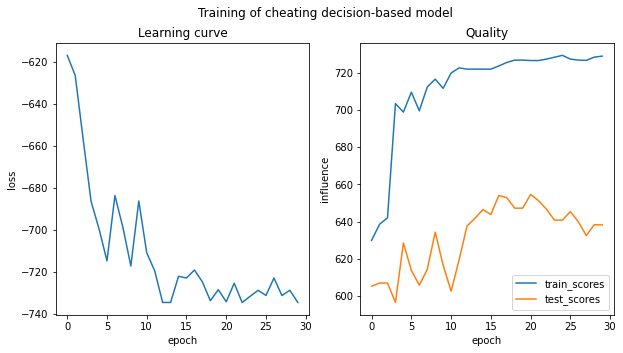

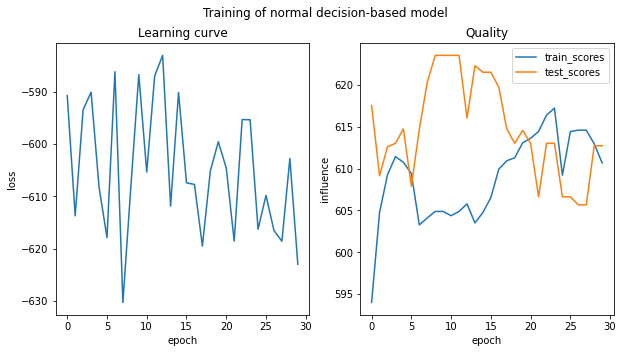

In [71]:
print_training(loss_df_cheat, train_df_cheat, test_df_cheat, "Training of cheating decision-based model")
print_training(loss_df, train_df, test_df, "Training of normal decision-based model")

Adding the topology of the graph

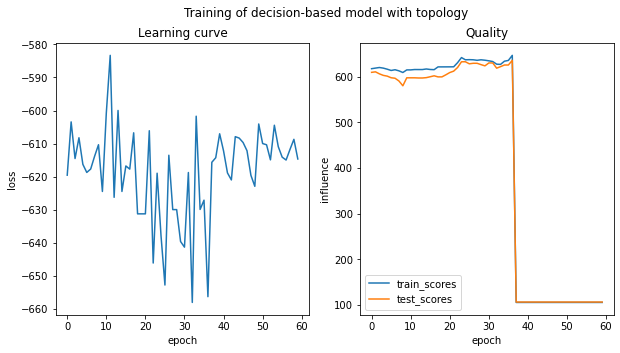

60


In [35]:

loss_df_topo = [-619.5857543945312, -603.4478759765625, -614.5478515625, -608.2476806640625, -616.3049926757812, -618.7550048828125, -617.7275390625, -613.8657836914062, -610.3626098632812, -624.5166625976562, -600.75830078125, -583.2958374023438, -626.2916259765625, -599.9833374023438, -624.5166625976562, -616.7916259765625, -617.7532958984375, -606.7527465820312, -631.2973022460938, -631.2973022460938, -631.2973022460938, -606.1243896484375, -646.1941528320312, -618.9900512695312, -637.9584350585938, -652.8555908203125, -613.5471801757812, -630.01025390625, -630.01025390625, -639.6707763671875, -641.3819580078125, -618.77880859375, -658.1292114257812, -601.7238159179688, -629.9630126953125, -627.1560668945312, -656.382568359375, -615.6832275390625, -614.3018188476562, -607.0485229492188, -612.2347412109375, -618.8964233398438, -621.024169921875, -607.9194946289062, -608.3514404296875, -609.6941528320312, -612.1798706054688, -619.6259765625, -622.9572143554688, -604.0802001953125, -610.0095825195312, -610.3702392578125, -614.9418334960938, -604.4588623046875, -610.9410400390625, -614.1242065429688, -615.000244140625, -611.7780151367188, -608.7266845703125, -614.6864013671875]
train_df_topo = [617.5399627685547, 618.8777694702148, 620.1529006958008, 618.7924041748047, 616.4651184082031, 613.6740798950195, 615.2547836303711, 612.8440399169922, 609.1955795288086, 614.9063873291016, 614.9063873291016, 615.7202453613281, 615.6787033081055, 615.6787033081055, 616.9194107055664, 615.8308639526367, 615.4168014526367, 621.4992523193359, 621.4992523193359, 621.5435333251953, 621.59130859375, 621.6975860595703, 630.6927795410156, 641.9276733398438, 637.0576858520508, 637.3375396728516, 637.0576858520508, 635.9438018798828, 637.0564041137695, 636.1268997192383, 634.7950973510742, 633.1996765136719, 627.4301223754883, 626.9901962280273, 633.9727172851562, 635.6409530639648, 646.7624893188477, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402]
test_df_topo = [609.572265625, 610.6583862304688, 606.2625732421875, 602.9145202636719, 601.2694702148438, 597.7141418457031, 596.6627502441406, 590.62109375, 580.1087341308594, 597.5809936523438, 597.5809936523438, 597.5809936523438, 597.2101440429688, 597.2101440429688, 597.9559631347656, 599.9073486328125, 601.9698791503906, 599.6156616210938, 599.6156616210938, 604.1601257324219, 609.0989990234375, 612.1927490234375, 620.1656188964844, 632.69580078125, 632.7374877929688, 628.2555541992188, 629.397216796875, 629.397216796875, 626.4708251953125, 623.7520751953125, 630.1479187011719, 630.1479187011719, 618.6668090820312, 622.0751037597656, 625.6167907714844, 625.6167907714844, 635.8049926757812, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484]

print_training(loss_df_topo, train_df_topo, test_df_topo, "Training of decision-based model with topology")


end